<a href="https://colab.research.google.com/github/apoorvap11/RML--Group-6/blob/main/assign_4_Group_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## License

Copyright 2021 - 2025  Apoorva Paranthaman (apoorvap@gwu.edu), Maryam Shabhaz Ali (maryamshahbaz.ali@gwmail.gwu.edu), Zahra Sultani (zahra.sultani@gwmail.gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

http://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.

DISCLAIMER: This notebook is not legal or compliance advice.

# Assignment 4 Template
With two calls to a blackbox prediction API we can craft adversarial examples to manipulate the model toward higher and lower predictions.

In [1]:
!pip install h2o
!pip install interpret
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 42.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 778.9/778.9 kB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━

#### Imports and inits

In [2]:
import h2o                                                        # h2o python library
from h2o.backend import H2OLocalServer                            # for model extraction
from h2o.estimators.random_forest import H2ORandomForestEstimator # for decision tree in model extraction
from interpret.glassbox import ExplainableBoostingClassifier      # interpret ebm class
from interpret.perf import ROC                                    # ROC measure for ebm
import matplotlib.pyplot as plt                                   # for plots
import numpy as np                                                # for basic array manipulation
import pandas as pd                                               # for dataframe manipulation
import subprocess                                                 # to run external processes for model extraction
import time                                                       # for timers

# enables display of images in notebook
from IPython.display import Image
from IPython.display import display

# set numpy random seed for better reproducibility
SEED = 12345
np.random.seed(SEED)

# set number of threads
NTHREAD = 4

h2o.init(max_mem_size='2G')      # start h2o
h2o.remove_all()                 # remove any existing data structures from h2o memory
h2o.no_progress()                # turn off h2o progress indicators

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpdk7ujp57
  JVM stdout: /tmp/tmpdk7ujp57/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpdk7ujp57/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         06 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.46.0.7
H2O_cluster_version_age:    1 month
H2O_cluster_name:           H2O_from_python_unknownUser_3nu3r0
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    2 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.11.12 final
--------------------------  -----------------------------------------------------------------------------------------

### Define Utility Functions

#### Utility function that trains a cross-validated decision tree

In [3]:
def get_cv_dt(x_names, y_name, train, model_id, seed_, title, valid=None):

    """ Utility function to train decision trees.
    Args:
        x_names: Names of input variables as a list.
        y_name: Name of target variable.
        train: Pandas DataFrame containing x_names and y_name on which to train
               decision tree.
        model_id: h2o model identifier.
        seed_: Random seed for improved reproducibility.
        title: Title for generated plot of tree.
        valid: Optional validation data.
    Returns:
        Model as h2o model object.
    """

    # initialize single tree model
    tree = H2ORandomForestEstimator(ntrees=1,  # use only one tree
                                    sample_rate=1,  # use all rows in that tree
                                    mtries=-2,  # use all columns in that tree's split search
                                    max_depth=4,  # shallow trees are easier to understand
                                    seed=seed_,  # set random seed for reproducibility
                                    nfolds=3,  # cross-validation for stability and ...
                                    # only way to get metrics for 1 tree in h2o
                                    model_id=model_id)  # gives MOJO artifact a recognizable name

    # train single tree model
    if valid is not None:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train), validation_frame=h2o.H2OFrame(valid))
    else:
        tree.train(x=x_names, y=y_name, training_frame=h2o.H2OFrame(train))

    # persist MOJO (compiled Java representation of trained model)
    # from which to generate plot of tree
    mojo_path = tree.download_mojo(path='.')
    print('Generated MOJO path:\n', mojo_path)

    return tree

#### Start global timer

In [4]:
tic = time.time()

In [5]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)
# may need to be updated to location on your drive
%cd drive/My\ Drive/GWU_RML/DNSC_6330_Software/data/
%ls

Mounted at /content/drive/
/content/drive/My Drive/GWU_RML/DNSC_6330_Software/data
ebm_grid_frame_12345.csv     ph_rem_ebm_2025_04_11_04_34_15.csv  stolen_dt.zip
hmda_test_preprocessed.csv   stolen_dt.gv
hmda_train_preprocessed.csv  stolen_dt.png


#### Import data

In [6]:
data = pd.read_csv('hmda_train_preprocessed.csv')

#### Assign basic modeling roles

In [7]:
y_name = 'high_priced'

## Fit interpretable model

#### Split data into train and validation partitions

In [8]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


### Explainable Boosting Machine

#### Retrain most accurate model above 0.8 AIR to act as blackbox prediction API

In [10]:
# params dict for remediated models
rem_params = {'max_bins': 256,
 'max_interaction_bins': 16,
 'interactions': 15,
 'outer_bags': 8,
 'inner_bags': 4,
 'learning_rate': 0.05,
 'validation_size': 0.1,
 'min_samples_leaf': 10,
 'max_leaves': 3,
 'n_jobs': 4,
 'early_stopping_rounds': 100,
 'random_state': 10001}

rem_x_names = ['no_intro_rate_period_std',
 'debt_to_income_ratio_missing',
 'income_std',
 'term_360',
 'conforming',
 'debt_to_income_ratio_std',
 'loan_amount_std']

# reset some parameters to integers
rem_params['random_state'] = int(rem_params['random_state'])
rem_params['n_jobs'] = int(rem_params['n_jobs'])
rem_params['early_stopping_rounds'] = int(rem_params['early_stopping_rounds'])

# retrain
rem_ebm = ExplainableBoostingClassifier(**rem_params)
rem_ebm.fit(train[rem_x_names], train[y_name])
rem_ebm_perf = ROC(rem_ebm.predict_proba).explain_perf(valid[rem_x_names], valid[y_name])
rem_auc = rem_ebm_perf._internal_obj['overall']['auc']
print('Remediated EBM retrained with AUC: %.4f.' % rem_auc)

Remediated EBM retrained with AUC: 0.7374.


## Model Extraction Attack

#### Generate synthetic data for extraction attack
For an API or model to be usable by customers or others, the system documentation must contain basic information about expected input variables. Between that information, domain knowledge, and publicly available information, an attacker can make a good guess at what the input data should look like.

In [11]:
# best guess at feature distributions
schema_dict = {'term_360':                     {'p': 0.9, 'dist': 'binomial'},
               'conforming':                   {'p': 0.9, 'dist': 'binomial'},
               'no_intro_rate_period_std':     {'p': 0.1, 'dist': 'binomial'},
               'loan_amount_std':              {'min': -5, 'scale': 10, 'dist': 'exponential'},
               'intro_rate_period_std':        {'min': 0, 'scale': 2, 'dist': 'exponential'},
               'property_value_std':           {'min': -5, 'scale': 5, 'dist': 'exponential'},
               'income_std':                   {'min': -5, 'scale': 25, 'dist': 'exponential'},
               'debt_to_income_ratio_std':     {'mean': 1, 'scale': 1, 'dist': 'normal'},
               'debt_to_income_ratio_missing': {'p': 0.1, 'dist': 'binomial'}}

N = 10000 # rows of simulated data

random_frame = pd.DataFrame(columns=list(schema_dict.keys())) # init empty frame

np.random.seed(SEED) # same results each time cell is run

for j in list(schema_dict.keys()): # loop through features

    # simulate normal features
    if schema_dict[j]['dist'] == 'normal':
        random_frame[j] = np.random.normal(loc=schema_dict[j]['mean'],
                                           scale=schema_dict[j]['scale'],
                                           size=N)

    # simulate expontential features
    if schema_dict[j]['dist'] == 'exponential':
        random_frame[j] = schema_dict[j]['min'] + np.random.exponential(scale=schema_dict[j]['scale'],
                                                                        size=N)

    # simulate binomial features
    if schema_dict[j]['dist'] == 'binomial':
        random_frame[j] = np.random.binomial(1, schema_dict[j]['p'], N)

# make up for no_intro_rate_period_std scale shift
random_frame['no_intro_rate_period_std'] = -4 * random_frame['no_intro_rate_period_std']

#### Visualize simulated data

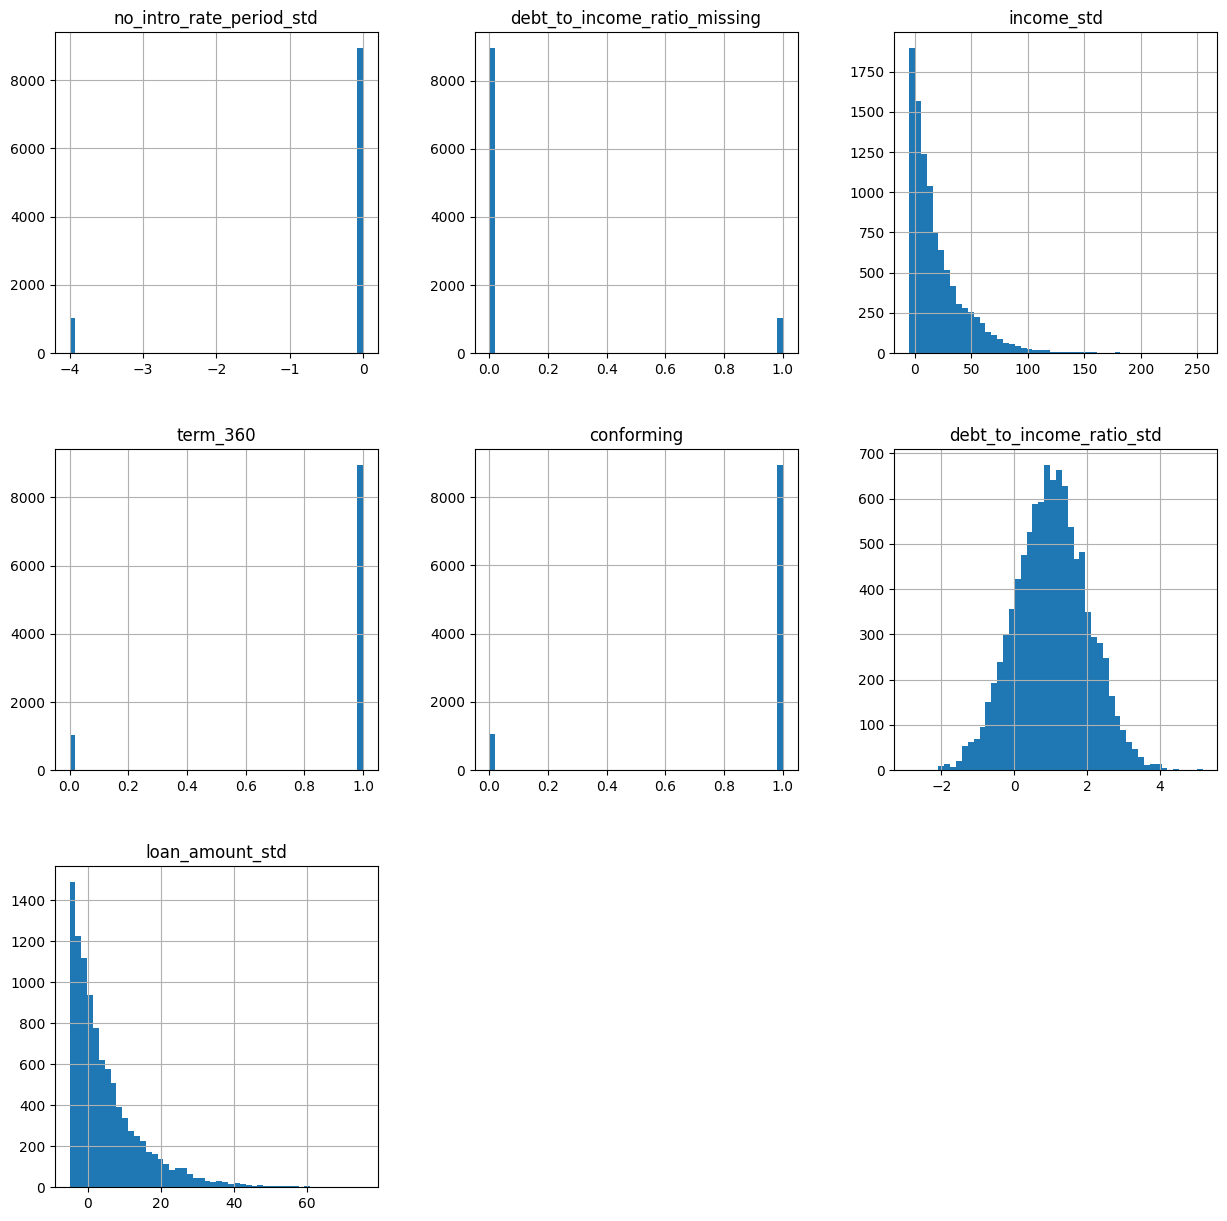

In [12]:
_ = random_frame[rem_x_names].hist(bins=50, figsize=(15, 15))

#### First call to blackbox model for predictions on random data

In [13]:
blackbox_phat = pd.DataFrame(rem_ebm.predict_proba(random_frame[rem_x_names])[:, 1], columns=['phat'])
blackbox_phat = pd.concat([random_frame.reset_index(drop=True), blackbox_phat], axis=1)
blackbox_phat.head()

term_360  conforming  no_intro_rate_period_std  loan_amount_std  \
0         0           1                         0         7.848707   
1         1           1                        -4        49.480298   
2         1           1                         0         0.014153   
3         1           1                         0         7.912400   
4         1           1                         0        -4.538403   

   intro_rate_period_std  property_value_std  income_std  \
0               2.018107            4.448038    7.560986   
1               1.029955            4.580346   -1.530707   
2               2.853882            8.899881   13.705550   
3               0.248822            8.887287    1.895881   
4               1.796115           -2.252657   27.529353   

   debt_to_income_ratio_std  debt_to_income_ratio_missing      phat  
0                  2.346077                             0  0.000689  
1                  0.239296                             0  0.016909  
2                  0.639075                             0  0.028394  
3                  0.087230                             0  0.002781  
4                  1.263036                             0  0.044174

#### Extract a stolen decision tree model

In [14]:
stolen_dt = get_cv_dt(list(schema_dict.keys()),
                      'phat',
                      blackbox_phat,
                      'stolen_dt',
                      SEED,
                      'Stolen Model')

# convert h2o MOJO (stolen_dt.zip) into GraphViz file (stolen_dt.png)
!java -cp "/usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar" hex.genmodel.tools.PrintMojo --tree 0 -i "stolen_dt.zip" -o stolen_dt.gv --title "Stolen Model"

# convert Graphviz file into png
!dot -Tpng stolen_dt.gv -o stolen_dt.png

# three new files should appear:
# - stolen_dt.zip
# - stolen_dt.gv
# - stolen_dt.png
%ls

Generated MOJO path:
 /content/drive/My Drive/GWU_RML/DNSC_6330_Software/data/stolen_dt.zip
ebm_grid_frame_12345.csv     ph_rem_ebm_2025_04_11_04_34_15.csv  stolen_dt.zip
hmda_test_preprocessed.csv   stolen_dt.gv
hmda_train_preprocessed.csv  stolen_dt.png


#### View stolen model
Double clicking should zoom.

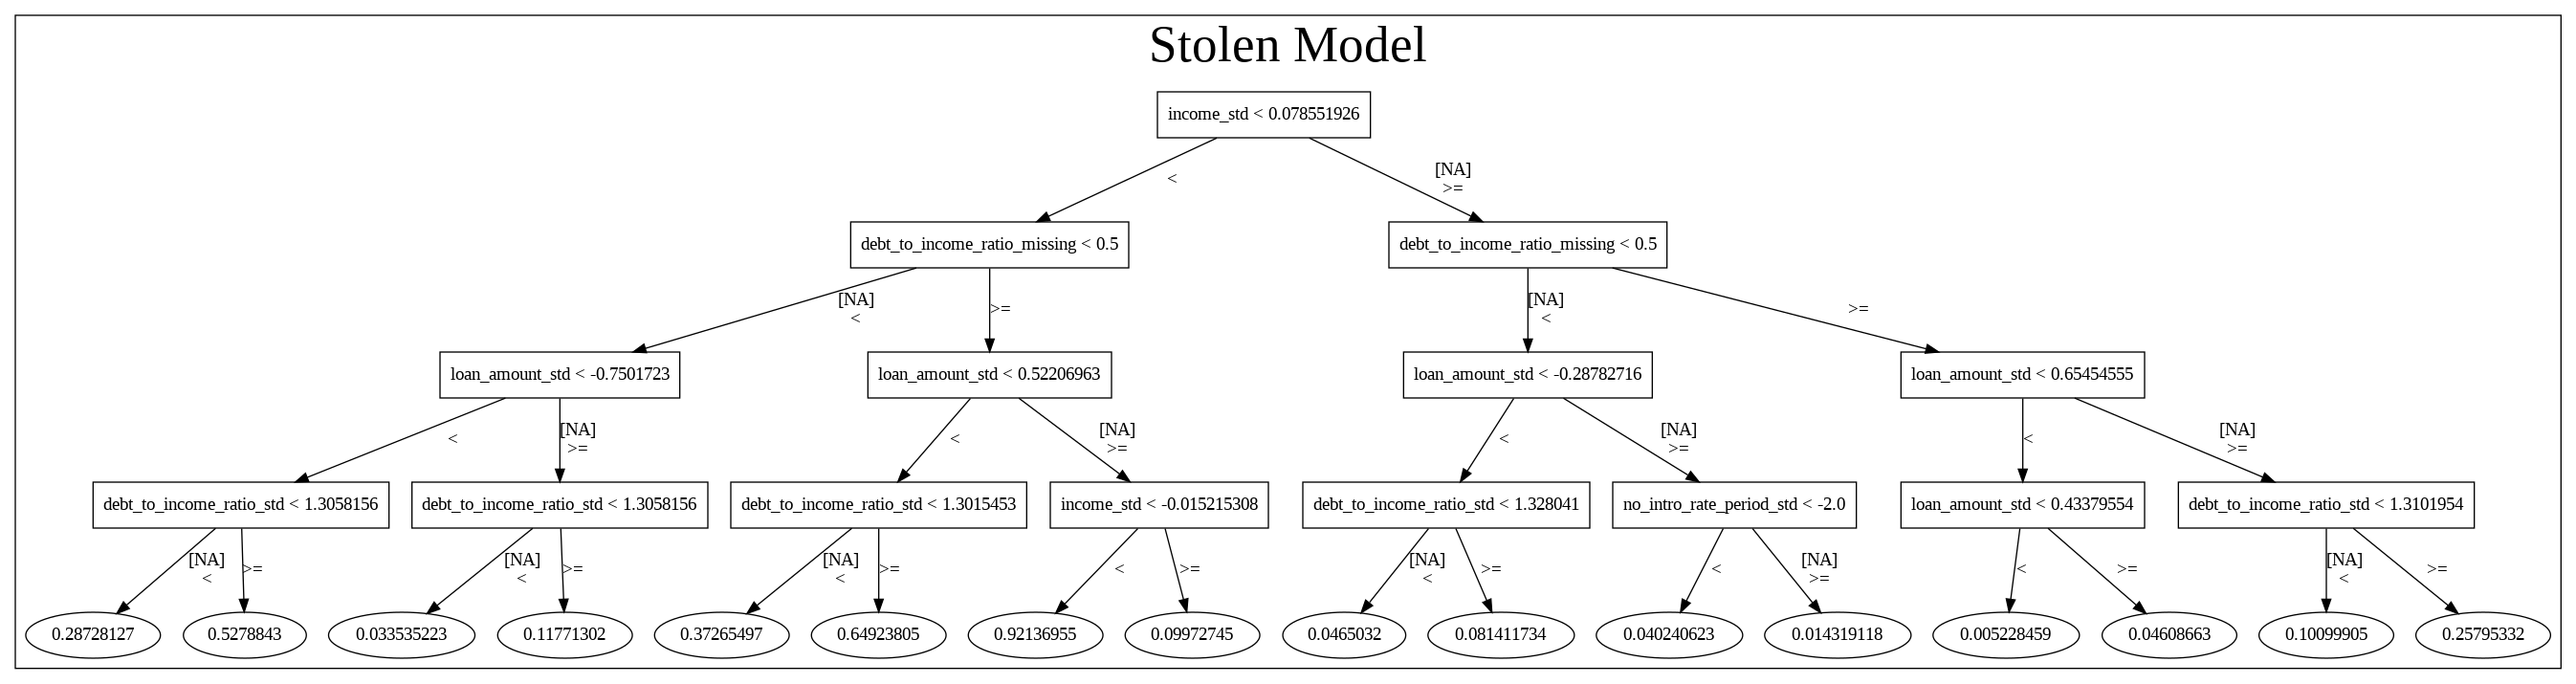

In [15]:
display(Image(('stolen_dt.png')))

Now an attacker has a basic flow chart for how the EBM works. This can be used as a sandbox for subsequent attacks!

#### Variable importance for stolen model

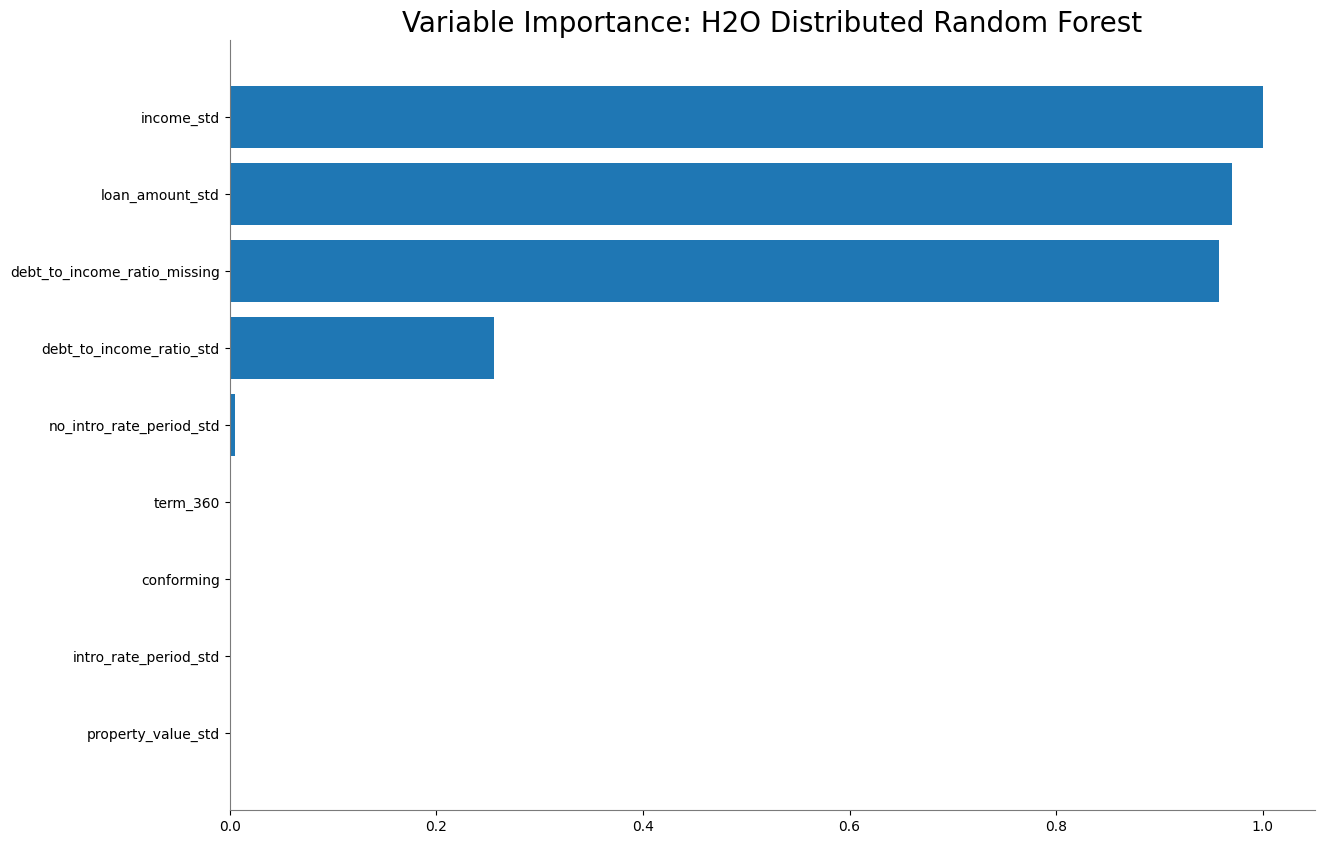

<Figure size 640x480 with 0 Axes>

In [16]:
stolen_dt.varimp_plot()

These are the most important variables in the stolen model, and likely in the real model too.

#### Assess accuracy of stolen model

In [17]:
stolen_dt.cross_validation_metrics_summary() # h2o makes cv evaluation metrics available

Cross-Validation Metrics Summary: 
                        mean        sd           cv_1_valid    cv_2_valid    cv_3_valid
----------------------  ----------  -----------  ------------  ------------  ------------
aic                     nan         0            nan           nan           nan
loglikelihood           nan         0            nan           nan           nan
mae                     0.0236818   0.00031936   0.023926      0.023799      0.0233204
mean_residual_deviance  0.00241504  0.000237056  0.002619      0.00247116    0.00215496
mse                     0.00241504  0.000237056  0.002619      0.00247116    0.00215496
r2                      0.881896    0.00691326   0.88095       0.875505      0.889234
residual_deviance       0.00241504  0.000237056  0.002619      0.00247116    0.00215496
rmse                    0.0491028   0.00243492   0.0511762     0.0497107     0.0464215
rmsle                   0.0386567   0.00151194   0.040049      0.0388726     0.0370484

The stolen model is accurate enough (R2=0.88, RMSE=0.05), and importantly, very stable.

## Use Stolen Model to Craft Adversarial Examples

#### Use stolen model to find seed rows for adversary searches

In [18]:
# Update the conditions to match the splits in your stolen decision tree image
low_adversary_seed = random_frame.loc[
    (random_frame['income_std'] >= 0.078) &
    (random_frame['debt_to_income_ratio_missing'] >= 0.5) &
    (random_frame['loan_amount_std'] < 0.654) &
    (random_frame['loan_amount_std'] < 0.433)
].mean()

print('Low adversarial example search seed row:')
print(low_adversary_seed)
print()

high_adversary_seed = random_frame.loc[
    (random_frame['income_std'] < 0.078) &
    (random_frame['debt_to_income_ratio_missing'] >= 0.5) &
    (random_frame['loan_amount_std'] >= 0.522) &
    (random_frame['income_std'] < -0.015)
].mean()

print('High adversarial example search seed row:')
print(high_adversary_seed)

Low adversarial example search seed row:
term_360                         0.902017
conforming                       0.893372
no_intro_rate_period_std        -0.357349
loan_amount_std                 -2.680568
intro_rate_period_std            1.873632
property_value_std              -0.059489
income_std                      28.029431
debt_to_income_ratio_std         1.013043
debt_to_income_ratio_missing     1.000000
dtype: float64

High adversarial example search seed row:
term_360                         0.954545
conforming                       0.827273
no_intro_rate_period_std        -0.509091
loan_amount_std                 11.204412
intro_rate_period_std            2.093809
property_value_std              -0.461484
income_std                      -2.867290
debt_to_income_ratio_std         1.146799
debt_to_income_ratio_missing     1.000000
dtype: float64


#### Perturb seed row to find low scoring adversarial examples

In [19]:
# init results frames
low_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys()))

# quantiles over which to search
low_quantiles = [0.01, 0.05, 0.1, 0.25, 0.5]
high_quantiles = [0.99, 0.95, 0.9, 0.75, 0.5]

idx = 0

# generate potential adversarial examples across four important features
# using values of each feature and seeded by information from stolen tree
for a in list(random_frame['property_value_std'].quantile(high_quantiles)):
        for b in list(random_frame['intro_rate_period_std'].quantile(high_quantiles)):
            for c in list(random_frame['debt_to_income_ratio_std'].quantile(low_quantiles)):
                for d in list(random_frame['term_360'].quantile(low_quantiles)):
                    low_adversary_seed_frame = pd.DataFrame(np.reshape(low_adversary_seed.values, (1, 9)), columns=list(schema_dict.keys()), index=[idx])
                    low_adversary_seed_frame['property_value_std'] = a
                    low_adversary_seed_frame['intro_rate_period_std'] = b
                    low_adversary_seed_frame['debt_to_income_ratio_std'] = c
                    low_adversary_seed_frame['term_360'] = d
                    low_adversary_frame = pd.concat([low_adversary_frame, low_adversary_seed_frame], axis=0)
                    idx += 1

# view potential low scoring adversarial examples
low_adversary_frame.head()

<ipython-input-19-db40e31a7262>:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  low_adversary_frame = pd.concat([low_adversary_frame, low_adversary_seed_frame], axis=0)


term_360  conforming  no_intro_rate_period_std  loan_amount_std  \
0       0.0    0.893372                 -0.357349        -2.680568   
1       0.0    0.893372                 -0.357349        -2.680568   
2       0.0    0.893372                 -0.357349        -2.680568   
3       1.0    0.893372                 -0.357349        -2.680568   
4       1.0    0.893372                 -0.357349        -2.680568   

   intro_rate_period_std  property_value_std  income_std  \
0                9.06958           18.545693   28.029431   
1                9.06958           18.545693   28.029431   
2                9.06958           18.545693   28.029431   
3                9.06958           18.545693   28.029431   
4                9.06958           18.545693   28.029431   

   debt_to_income_ratio_std  debt_to_income_ratio_missing  
0                  -1.29433                           1.0  
1                  -1.29433                           1.0  
2                  -1.29433                           1.0  
3                  -1.29433                           1.0  
4                  -1.29433                           1.0

#### Perturb seed row to find high scoring adversarial examples

In [20]:
# init results frames
high_adversary_frame = pd.DataFrame(columns=list(schema_dict.keys()))

idx = 0

# generate potential adversarial examples across four important features
# using values of each feature and seeded by information from stolen tree
for a in list(random_frame['property_value_std'].quantile(low_quantiles)):
        for b in list(random_frame['intro_rate_period_std'].quantile(low_quantiles)):
            for c in list(random_frame['debt_to_income_ratio_std'].quantile(high_quantiles)):
                for d in list(random_frame['term_360'].quantile(high_quantiles)):
                    high_adversary_seed_frame = pd.DataFrame(np.reshape(high_adversary_seed.values, (1, 9)), columns=list(schema_dict.keys()), index=[idx])
                    high_adversary_seed['property_value_std'] = a
                    high_adversary_seed['intro_rate_period_std'] = b
                    high_adversary_seed['debt_to_income_ratio_std'] = c
                    high_adversary_seed['term_360'] = d
                    high_adversary_frame = pd.concat([high_adversary_frame, high_adversary_seed_frame], axis=0)
                    idx += 1

# view potential high scoring adversarial examples
high_adversary_frame.head()

<ipython-input-20-207379f6aa02>:17: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  high_adversary_frame = pd.concat([high_adversary_frame, high_adversary_seed_frame], axis=0)


term_360  conforming  no_intro_rate_period_std  loan_amount_std  \
0       1.0    0.827273                 -0.509091        11.204412   
1       1.0    0.827273                 -0.509091        11.204412   
2       1.0    0.827273                 -0.509091        11.204412   
3       1.0    0.827273                 -0.509091        11.204412   
4       1.0    0.827273                 -0.509091        11.204412   

   intro_rate_period_std  property_value_std  income_std  \
0               0.018175           -4.946902    -2.86729   
1               0.018175           -4.946902    -2.86729   
2               0.018175           -4.946902    -2.86729   
3               0.018175           -4.946902    -2.86729   
4               0.018175           -4.946902    -2.86729   

   debt_to_income_ratio_std  debt_to_income_ratio_missing  
0                  3.322541                           1.0  
1                  3.322541                           1.0  
2                  3.322541                           1.0  
3                  3.322541                           1.0  
4                  3.322541                           1.0

#### Second call to blackbox API to test adversarial examples

In [21]:
# combine potential adversaries so only one call to API is needed
adversaries = pd.concat([low_adversary_frame, high_adversary_frame], axis=0)

# score potential adversarial examples to understand their effect on generated predictions
blackbox_adversaries_phat = pd.DataFrame(rem_ebm.predict_proba(adversaries[rem_x_names])[:, 1], columns=['phat'])
blackbox_adversaries_phat = pd.concat([adversaries.reset_index(drop=True), blackbox_adversaries_phat], axis=1)
blackbox_adversaries_phat.sort_values(by='phat')

term_360  conforming  no_intro_rate_period_std  loan_amount_std  \
621       0.0    0.893372                 -0.357349        -2.680568   
622       0.0    0.893372                 -0.357349        -2.680568   
596       0.0    0.893372                 -0.357349        -2.680568   
395       0.0    0.893372                 -0.357349        -2.680568   
396       0.0    0.893372                 -0.357349        -2.680568   
..        ...         ...                       ...              ...   
636       1.0    0.827273                 -0.509091        11.204412   
637       1.0    0.827273                 -0.509091        11.204412   
638       1.0    0.827273                 -0.509091        11.204412   
639       1.0    0.827273                 -0.509091        11.204412   
640       1.0    0.827273                 -0.509091        11.204412   

     intro_rate_period_std  property_value_std  income_std  \
621               1.383623           -1.487777   28.029431   
622               1.383623           -1.487777   28.029431   
596               2.743916           -1.487777   28.029431   
395               9.069580            1.851136   28.029431   
396               9.069580            1.851136   28.029431   
..                     ...                 ...         ...   
636               0.018175           -4.946902   -2.867290   
637               0.018175           -4.946902   -2.867290   
638               0.018175           -4.946902   -2.867290   
639               0.018175           -4.946902   -2.867290   
640               0.018175           -4.946902   -2.867290   

     debt_to_income_ratio_std  debt_to_income_ratio_missing      phat  
621                  1.018130                           1.0  0.000620  
622                  1.018130                           1.0  0.000620  
596                  1.018130                           1.0  0.000620  
395                  1.018130                           1.0  0.000620  
396                  1.018130                           1.0  0.000620  
..                        ...                           ...       ...  
636                  2.325711                           1.0  0.984534  
637                  2.325711                           1.0  0.984534  
638                  2.325711                           1.0  0.984534  
639                  2.325711                           1.0  0.984534  
640                  1.686577                           1.0  0.984534  

[1250 rows x 10 columns]

#### End timer

In [22]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))

All tasks completed in 1084.50 s.


#### Shutdown H2O

In [23]:
# be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://127.0.0.1:54321 (Y/N)? Y
H2O session _sid_89a7 closed.
